In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely import wkt
import contextily as ctx

In [9]:
homicide_data = pd.read_csv(r'C:\Users\abelma2\Desktop\MASTERS\SPRING 2025\ACE592\ACE592_FinalProject\clean_data\Homicide_six_hoods.csv')
shotspotter_data = pd.read_csv(r'C:\Users\abelma2\Desktop\MASTERS\SPRING 2025\ACE592\ACE592_FinalProject\clean_data\Shotspotter_six_hoods.csv')
streets = pd.read_csv(r"C:\Users\abelma2\Desktop\MASTERS\SPRING 2025\ACE592\ACE592_FinalProject\data\transportation_20250415.csv")
chicago_shapefile = gpd.read_file(r'C:/Users/abelma2/Desktop/MASTERS/SPRING 2025/ACE592/ACE592_FinalProject/data/CommAreas_20250408.geojson')

In [10]:
chicago_shapefile.rename(columns={
    "community area": "community"}, inplace=True)

chicago_shapefile.loc[:, "community"] = chicago_shapefile["community"].str.title()

homicide_data['geometry'] = gpd.points_from_xy(homicide_data['Longitude'], homicide_data['Latitude'])
shotspotter_data['geometry'] = gpd.points_from_xy(shotspotter_data['Longitude'], shotspotter_data['Latitude'])
homicide_gdf = gpd.GeoDataFrame(homicide_data, geometry='geometry', crs='EPSG:4326')
shotspotter_gdf = gpd.GeoDataFrame(shotspotter_data, geometry='geometry', crs='EPSG:4326')

streets['geometry'] = streets['the_geom'].apply(wkt.loads)
streets_gdf = gpd.GeoDataFrame(streets, geometry='geometry', crs='EPSG:4326')

chicago_shapefile = chicago_shapefile.to_crs('EPSG:3857')
homicide_gdf = homicide_gdf.to_crs('EPSG:3857')
shotspotter_gdf = shotspotter_gdf.to_crs('EPSG:3857')
streets_gdf = streets_gdf.to_crs('EPSG:3857')

In [11]:
def create_grid(neighborhood_geom, grid_size=150):
    minx, miny, maxx, maxy = neighborhood_geom.bounds
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)
    grids = []
    for x in x_coords:
        for y in y_coords:
            grids.append(Polygon([(x, y), (x + grid_size, y), (x + grid_size, y + grid_size), (x, y + grid_size)]))
    return gpd.GeoDataFrame({'geometry': grids}, crs='EPSG:3857')

def assign_to_grid(incident_gdf, grid_gdf):
    joined = gpd.sjoin(incident_gdf, grid_gdf, how='left', predicate='intersects')
    grid_counts = joined.groupby('index_right').size()
    grid_gdf['count'] = grid_gdf.index.map(grid_counts)
    grid_gdf['count'] = grid_gdf['count'].fillna(0)
    return grid_gdf

def visualize_6x3_layout(homicide_gdf, shotspotter_gdf, streets_gdf, chicago_shapefile, selected_neighborhoods):
    fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(22, 36), constrained_layout=True)
    
    pre_2017 = homicide_gdf[homicide_gdf['Date'] < '2017-01-01']
    post_2017 = homicide_gdf[homicide_gdf['Date'] >= '2017-01-01']
    
    buffer_distance = 1609  # 1 mile in meters

    for idx, neighborhood in enumerate(selected_neighborhoods):
        ax1, ax2, ax3 = axes[idx]

        neighborhood_geom = chicago_shapefile[chicago_shapefile['community'] == neighborhood].geometry.values[0]
        neighborhood_buffer = neighborhood_geom.buffer(buffer_distance)

        pre_grid_gdf = create_grid(neighborhood_geom, grid_size=150)
        post_grid_gdf = create_grid(neighborhood_geom, grid_size=150)
        shotspotter_grid_gdf = create_grid(neighborhood_geom, grid_size=150)

        pre_grid = assign_to_grid(pre_2017, pre_grid_gdf)
        post_grid = assign_to_grid(post_2017, post_grid_gdf)
        shotspotter_grid = assign_to_grid(shotspotter_gdf, shotspotter_grid_gdf)

        def plot_background(ax):

            streets_gdf.plot(ax=ax, color='dimgray', linewidth=0.7, alpha=0.7)
            ax.grid(visible=True, color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.5)
            ctx.add_basemap(ax, crs='EPSG:3857', source=ctx.providers.CartoDB.Positron, alpha=0.3)
            ax.set_xlim(neighborhood_buffer.bounds[0], neighborhood_buffer.bounds[2])
            ax.set_ylim(neighborhood_buffer.bounds[1], neighborhood_buffer.bounds[3])
            ax.axis('off')

        plot_background(ax1)
        pre_grid.plot(ax=ax1, column='count', cmap='OrRd', legend=False, alpha=0.7)
        gpd.GeoDataFrame(geometry=[neighborhood_geom], crs='EPSG:3857').boundary.plot(ax=ax1, color='black', linewidth=1.5)
        ax1.set_title(f"{neighborhood} - Homicide Pre-2017")

        plot_background(ax2)
        shotspotter_grid.plot(ax=ax2, column='count', cmap='Blues', legend=False, alpha=0.7)
        gpd.GeoDataFrame(geometry=[neighborhood_geom], crs='EPSG:3857').boundary.plot(ax=ax2, color='black', linewidth=1.5)
        ax2.set_title(f"{neighborhood} - ShotSpotter")

        plot_background(ax3)
        post_grid.plot(ax=ax3, column='count', cmap='OrRd', legend=False, alpha=0.7)
        gpd.GeoDataFrame(geometry=[neighborhood_geom], crs='EPSG:3857').boundary.plot(ax=ax3, color='black', linewidth=1.5)
        ax3.set_title(f"{neighborhood} - Homicide Post-2017")

    sm_homicide = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=0, vmax=pre_grid['count'].max()))
    sm_shotspot = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=shotspotter_grid['count'].max()))
    fig.colorbar(sm_homicide, ax=axes[:, 0], orientation='vertical', fraction=0.02, pad=0.02, label='Homicide Count Pre-2017')
    fig.colorbar(sm_shotspot, ax=axes[:, 1], orientation='vertical', fraction=0.02, pad=0.02, label='ShotSpotter Count')
    fig.colorbar(sm_homicide, ax=axes[:, 2], orientation='vertical', fraction=0.02, pad=0.02, label='Homicide Count Post-2017')

    plt.suptitle("Homicide and ShotSpotter Analysis by Chicago Neighborhood ", fontsize=16, fontweight='bold')
    plt.show()


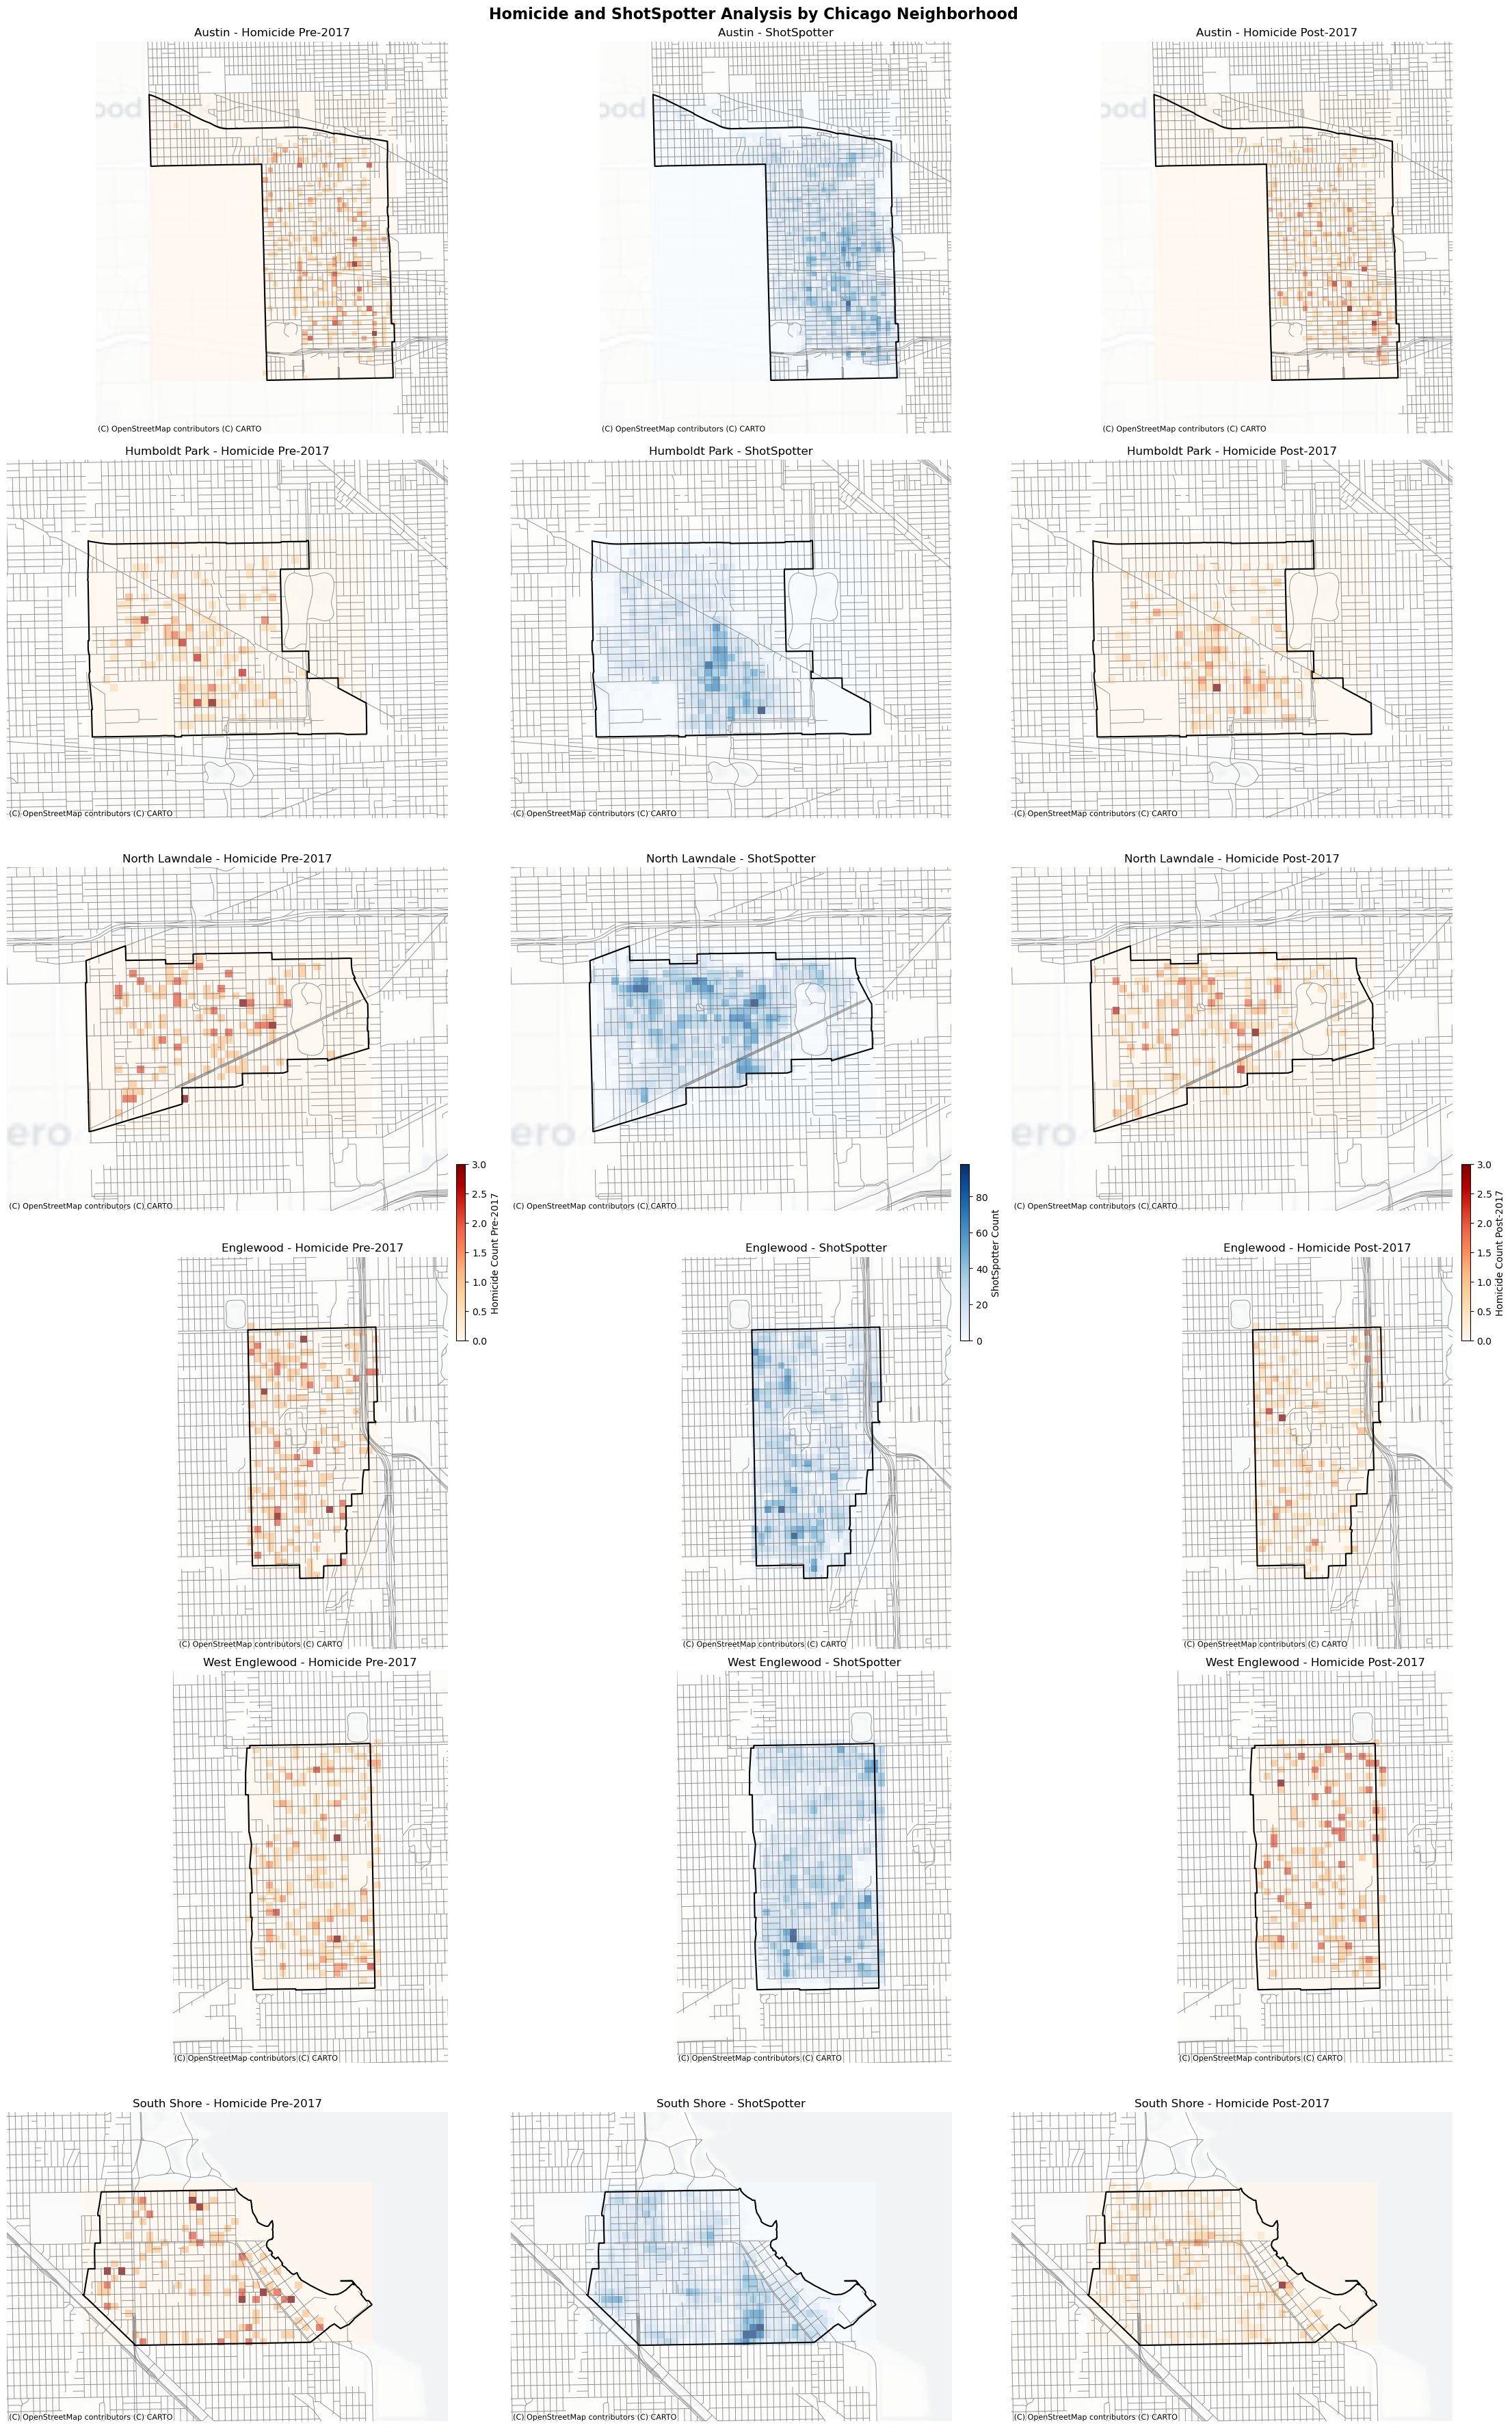

In [12]:
selected_neighborhoods = ['Austin', 'Humboldt Park', 'North Lawndale', 'Englewood', 'West Englewood', 'South Shore']

visualize_6x3_layout(homicide_gdf, shotspotter_gdf, streets_gdf, chicago_shapefile, selected_neighborhoods)